In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv
/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv


**Importing required libraries**

In [2]:
import string
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import f1_score, make_scorer

**Loading train and movie datasets**

In [3]:
train = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/train.csv')
movie = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/movies.csv')

**Joining train and movie datasets**

In [4]:
mid = 'movieid'
mov = movie.drop_duplicates(subset=mid, keep='first')
join = train.merge(mov, on='movieid', how='left')
print(join.shape)
join.dtypes 

(162758, 18)


movieid                  object
reviewerName             object
isFrequentReviewer         bool
reviewText               object
sentiment                object
title                    object
audienceScore           float64
rating                   object
ratingContents           object
releaseDateTheaters      object
releaseDateStreaming     object
runtimeMinutes          float64
genre                    object
originalLanguage         object
director                 object
boxOffice                object
distributor              object
soundType                object
dtype: object

**Dropping unimportant columns**

In [5]:
join = join.drop(columns=['movieid', 'reviewerName', 'title', 'releaseDateTheaters', 'releaseDateStreaming', 'director', 'distributor', 'soundType'])
join = join.rename(columns={'isFrequentReviewer': 'isTopCritic'})
join = join.dropna(subset=['reviewText'])
print(join.shape)
print(join.dtypes)
join.head()

(156311, 10)
isTopCritic            bool
reviewText           object
sentiment            object
audienceScore       float64
rating               object
ratingContents       object
runtimeMinutes      float64
genre                object
originalLanguage     object
boxOffice            object
dtype: object


,isTopCritic,reviewText,sentiment,audienceScore,rating,ratingContents,runtimeMinutes,genre,originalLanguage,boxOffice
0,False,Henry Selick’s first movie since 2009’s Corali...,POSITIVE,65.0,PG-13,"['Violence', 'Brief Strong Language', 'Substan...",105.0,"Comedy, Animation, Adventure, Fantasy",English,NaN
1,False,With a cast that reads like the Vogue Oscar pa...,NEGATIVE,NaN,NaN,NaN,91.0,Action,English,NaN
2,True,Creed II does not give us anything but another...,POSITIVE,80.0,PG-13,"['Language', 'A Scene of Sensuality', 'Sports ...",130.0,Drama,English,$115.7M
3,False,"I know what you're thinking, but this is no Li...",POSITIVE,NaN,NaN,NaN,15.0,Drama,Spanish,NaN
4,False,Director Fernando Meirelles tells the story wi...,POSITIVE,97.0,R,"['Language', 'Drug Content', 'Sexuality', 'Str...",131.0,"Crime, Drama",Portuguese (Brazil),$7.6M


In [6]:
join.nunique()

isTopCritic              2
reviewText          155071
sentiment                2
audienceScore           99
rating                   7
ratingContents        4460
runtimeMinutes         216
genre                 1157
originalLanguage        91
boxOffice             3481
dtype: int64

In [7]:
print('isTopCritic:', join['isTopCritic'].value_counts())
print('sentiment:', join['sentiment'].value_counts())
print('rating:', join['rating'].value_counts())
print('originalLanguage:', join['originalLanguage'].value_counts())

isTopCritic: False    107748
True      48563
Name: isTopCritic, dtype: int64
sentiment: POSITIVE    104719
NEGATIVE     51592
Name: sentiment, dtype: int64
rating: R        49383
PG-13    35801
PG       11519
NC-17      197
TVPG       188
TV14       139
TVMA        41
Name: rating, dtype: int64
originalLanguage: English                     127229
French (France)               3250
English (United Kingdom)      3172
French (Canada)               2101
Japanese                      1834
                             ...  
Irish                            3
Slovenian                        2
Somali                           2
Latvian                          1
Azerbaijani                      1
Name: originalLanguage, Length: 91, dtype: int64


**Concatenating "reviewText" and "ratingContents" into a single text column**

In [8]:
join["ratingContents"] = join["ratingContents"].fillna("the")

def remove_punctuations(text):
    return text.translate(str.maketrans('', '', string.punctuation))

join["reviewText"] = join["reviewText"].apply(remove_punctuations)
join["ratingContents"] = join["ratingContents"].apply(remove_punctuations)

join['com_col'] = join['reviewText'] + ' '+ join['ratingContents']
join = join.drop(columns=['reviewText','ratingContents'])
join.head()

,isTopCritic,sentiment,audienceScore,rating,runtimeMinutes,genre,originalLanguage,boxOffice,com_col
0,False,POSITIVE,65.0,PG-13,105.0,"Comedy, Animation, Adventure, Fantasy",English,NaN,Henry Selick’s first movie since 2009’s Corali...
1,False,NEGATIVE,NaN,NaN,91.0,Action,English,NaN,With a cast that reads like the Vogue Oscar pa...
2,True,POSITIVE,80.0,PG-13,130.0,Drama,English,$115.7M,Creed II does not give us anything but another...
3,False,POSITIVE,NaN,NaN,15.0,Drama,Spanish,NaN,I know what youre thinking but this is no Limi...
4,False,POSITIVE,97.0,R,131.0,"Crime, Drama",Portuguese (Brazil),$7.6M,Director Fernando Meirelles tells the story wi...


In [9]:
null_counts = join.isnull().sum()
print(null_counts)

isTopCritic             0
sentiment               0
audienceScore       12757
rating              59043
runtimeMinutes       3252
genre                2346
originalLanguage     3143
boxOffice           50353
com_col                 0
dtype: int64


**One hot encoding required columns**

In [10]:
rating_oh = pd.get_dummies(join['rating'])
rating_oh.columns = 'rating_' + rating_oh.columns
join = pd.concat([join, rating_oh], axis=1)
join.drop('rating', axis=1, inplace=True)

In [11]:
join["genre"] = join["genre"].fillna("")
join["genre"] = join["genre"].apply(remove_punctuations)
join['genre'] = join['genre'].str.lower()
join['genre'] = join['genre'].str.replace('  ', ' ')
genre_oh = join['genre'].str.get_dummies(sep=' ')
genre_oh.columns = 'genre_' + genre_oh.columns
join = pd.concat([join, genre_oh], axis=1)
join.drop('genre', axis=1, inplace=True)

In [12]:
lang_oh = pd.get_dummies(join['originalLanguage'])
lang_oh.columns = 'lang_' + lang_oh.columns
join = pd.concat([join, lang_oh], axis=1)
join.drop('originalLanguage', axis=1, inplace=True)
join.head()

,isTopCritic,sentiment,audienceScore,runtimeMinutes,boxOffice,com_col,rating_NC-17,rating_PG,rating_PG-13,rating_R,...,lang_Turkish,lang_Ukrainian,lang_Unknown language,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Wolof,lang_Xhosa,lang_Yiddish,lang_crp
0,False,POSITIVE,65.0,105.0,NaN,Henry Selick’s first movie since 2009’s Corali...,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,False,NEGATIVE,NaN,91.0,NaN,With a cast that reads like the Vogue Oscar pa...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,POSITIVE,80.0,130.0,$115.7M,Creed II does not give us anything but another...,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,False,POSITIVE,NaN,15.0,NaN,I know what youre thinking but this is no Limi...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,POSITIVE,97.0,131.0,$7.6M,Director Fernando Meirelles tells the story wi...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


In [13]:
def convert_box_office(value):
    if pd.notna(value):
        if 'B' in value:
            return float(value.replace('$', '').replace('B', '')) * 1000000000
        elif 'M' in value:
            return float(value.replace('$', '').replace('M', '')) * 1000000
        elif 'K' in value:
            return float(value.replace('$', '').replace('K', '')) * 1000
        else:
            return float(value.replace('$', ''))
    else:
        return value
join['boxOffice'] = join['boxOffice'].apply(convert_box_office)

In [14]:
join.describe()

,audienceScore,runtimeMinutes,boxOffice,rating_NC-17,rating_PG,rating_PG-13,rating_R,rating_TV14,rating_TVMA,rating_TVPG,...,lang_Turkish,lang_Ukrainian,lang_Unknown language,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Wolof,lang_Xhosa,lang_Yiddish,lang_crp
count,143554.000000,153059.000000,1.059580e+05,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,...,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000,156311.000000
mean,65.239436,106.988736,5.074940e+07,0.001260,0.073693,0.229037,0.315928,0.000889,0.000262,0.001203,...,0.000819,0.000186,0.001171,0.000128,0.000320,0.000077,0.000128,0.000026,0.000224,0.000051
std,19.915823,22.101083,9.127036e+07,0.035479,0.261271,0.420214,0.464886,0.029807,0.016194,0.034660,...,0.028604,0.013620,0.034196,0.011311,0.017882,0.008762,0.011311,0.005059,0.014962,0.007154
min,0.000000,4.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,51.000000,93.000000,9.789000e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,68.000000,104.000000,1.500000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,82.000000,118.000000,5.820000e+07,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,100.000000,561.000000,8.584000e+08,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


**Imputation of numerical features**

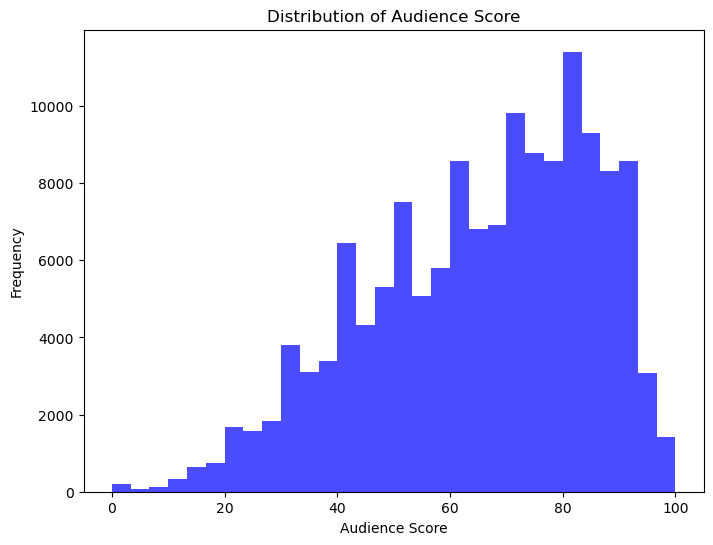

In [15]:
plt.figure(figsize=(8, 6))
plt.hist(join['audienceScore'], bins=30, color='blue', alpha=0.7)

plt.xlabel('Audience Score')
plt.ylabel('Frequency')
plt.title('Distribution of Audience Score')

plt.show()

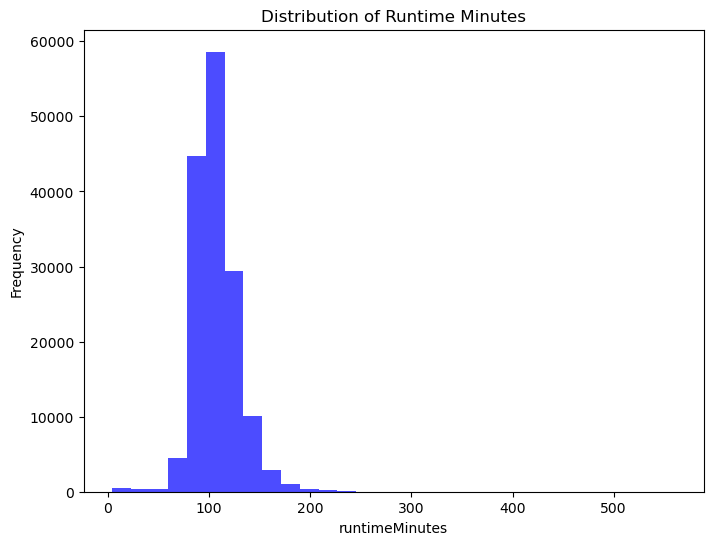

In [16]:
plt.figure(figsize=(8, 6))
plt.hist(join['runtimeMinutes'], bins=30, color='blue', alpha=0.7)

plt.xlabel('runtimeMinutes')
plt.ylabel('Frequency')
plt.title('Distribution of Runtime Minutes')

plt.show()

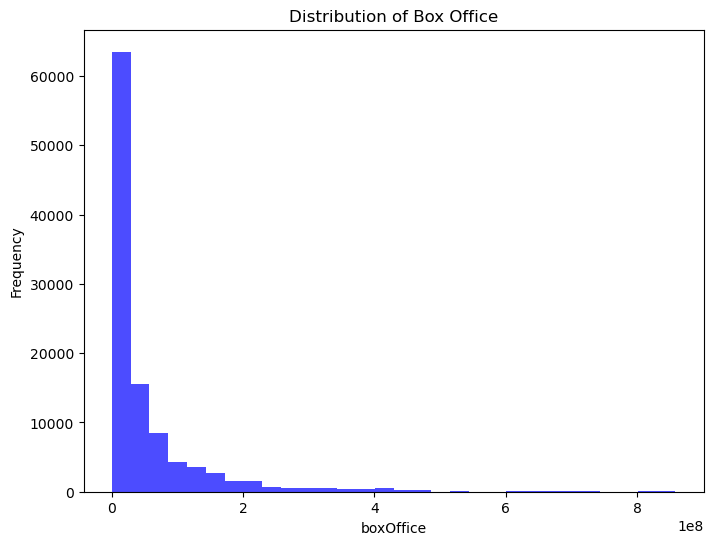

In [17]:
plt.figure(figsize=(8, 6))
plt.hist(join['boxOffice'], bins=30, color='blue', alpha=0.7)

plt.xlabel('boxOffice')
plt.ylabel('Frequency')
plt.title('Distribution of Box Office')

plt.show()

In [18]:
from sklearn.impute import SimpleImputer
mean_imputer = SimpleImputer(strategy='mean')
median_imputer = SimpleImputer(strategy='median')

mean_columns = ['audienceScore', 'runtimeMinutes']
median_columns = ['boxOffice']

join[mean_columns] = mean_imputer.fit_transform(join[mean_columns])
join[median_columns] = median_imputer.fit_transform(join[median_columns])

print(join.shape)
join.head()

(156311, 143)


,isTopCritic,sentiment,audienceScore,runtimeMinutes,boxOffice,com_col,rating_NC-17,rating_PG,rating_PG-13,rating_R,...,lang_Turkish,lang_Ukrainian,lang_Unknown language,lang_Urdu,lang_Vietnamese,lang_Welsh,lang_Wolof,lang_Xhosa,lang_Yiddish,lang_crp
0,False,POSITIVE,65.000000,105.0,15000000.0,Henry Selick’s first movie since 2009’s Corali...,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,False,NEGATIVE,65.239436,91.0,15000000.0,With a cast that reads like the Vogue Oscar pa...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,True,POSITIVE,80.000000,130.0,115700000.0,Creed II does not give us anything but another...,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,False,POSITIVE,65.239436,15.0,15000000.0,I know what youre thinking but this is no Limi...,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,False,POSITIVE,97.000000,131.0,7600000.0,Director Fernando Meirelles tells the story wi...,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0


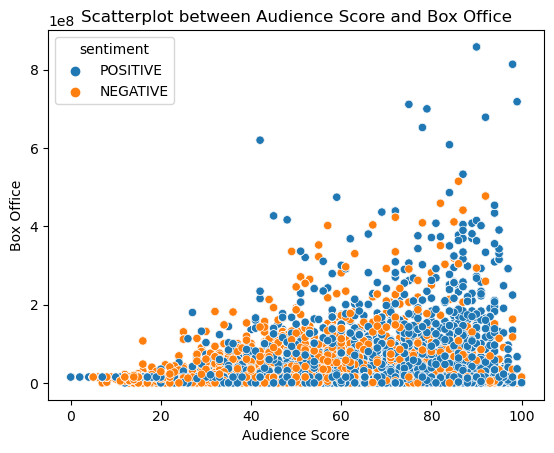

In [19]:
sns.scatterplot(data=join, x='audienceScore', y='boxOffice', hue='sentiment')
plt.title('Scatterplot between Audience Score and Box Office')
plt.xlabel('Audience Score')
plt.ylabel('Box Office')
plt.show()

In [20]:
new_null_counts = join.isnull().sum()
print(new_null_counts)

isTopCritic       0
sentiment         0
audienceScore     0
runtimeMinutes    0
boxOffice         0
                 ..
lang_Welsh        0
lang_Wolof        0
lang_Xhosa        0
lang_Yiddish      0
lang_crp          0
Length: 143, dtype: int64


In [21]:
all_column_names = join.columns.tolist()
print(all_column_names)
print(join.shape)

['isTopCritic', 'sentiment', 'audienceScore', 'runtimeMinutes', 'boxOffice', 'com_col', 'rating_NC-17', 'rating_PG', 'rating_PG-13', 'rating_R', 'rating_TV14', 'rating_TVMA', 'rating_TVPG', 'genre_action', 'genre_adventure', 'genre_animation', 'genre_anime', 'genre_biography', 'genre_comedy', 'genre_crime', 'genre_documentary', 'genre_drama', 'genre_faith', 'genre_family', 'genre_fantasy', 'genre_fitness', 'genre_foreign', 'genre_gay', 'genre_health', 'genre_history', 'genre_holiday', 'genre_horror', 'genre_kids', 'genre_lesbian', 'genre_lgbtq', 'genre_music', 'genre_musical', 'genre_mystery', 'genre_nature', 'genre_news', 'genre_other', 'genre_romance', 'genre_scifi', 'genre_short', 'genre_spirituality', 'genre_sports', 'genre_standup', 'genre_thriller', 'genre_variety', 'genre_war', 'genre_wellness', 'genre_western', 'lang_Afrikaans', 'lang_Albanian', 'lang_Amharic', 'lang_Arabic', 'lang_Aramaic', 'lang_Armenian', 'lang_Azerbaijani', 'lang_Bambara', 'lang_Bangla', 'lang_Bosnian', 'la

**Extracting appropriate numerical features from text using TfIdf Vectorizer**

In [22]:
print("Original join shape:", join.shape)
rt = TfidfVectorizer(max_features=1800)
tfidf_rt = rt.fit_transform(join["com_col"])
tfidf_df = pd.DataFrame(tfidf_rt.toarray(), columns=[f"tf_{name}" for name in rt.get_feature_names_out()])
print("TF-IDF matrix shape:", tfidf_df.shape)
tfidf_df.reset_index(drop=True, inplace=True)
join.reset_index(drop=True, inplace=True)
join = pd.concat([join, tfidf_df], axis=1)
join.drop('com_col', axis=1, inplace=True)
print("Concatenated join shape:", join.shape)
x = join.drop(columns=['sentiment'])
y = join['sentiment']

Original join shape: (156311, 143)
TF-IDF matrix shape: (156311, 1800)
Concatenated join shape: (156311, 1942)


In [23]:
print(x.shape)
print(x.dtypes)
print("--")
print(y.shape)
print(y.dtypes)
y.head()

(156311, 1941)
isTopCritic          bool
audienceScore     float64
runtimeMinutes    float64
boxOffice         float64
rating_NC-17        uint8
                   ...   
tf_youre          float64
tf_yourself       float64
tf_youth          float64
tf_youve          float64
tf_zombie         float64
Length: 1941, dtype: object
--
(156311,)
object


0    POSITIVE
1    NEGATIVE
2    POSITIVE
3    POSITIVE
4    POSITIVE
Name: sentiment, dtype: object

**Balancing the dataset using SMOTE oversampling**

In [24]:
print('before smote')
print(x.shape)
print(y.shape)

before smote
(156311, 1941)
(156311,)


In [25]:
smote = SMOTE(random_state=42)
x, y = smote.fit_resample(x, y)

In [26]:
print('after smote')
print(x.shape)
print(y.shape)

after smote
(209438, 1941)
(209438,)


**Splitting and scaling the dataset**

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(167550, 1941)
(167550,)
(41888, 1941)
(41888,)


In [28]:
'''pca = PCA(n_components=0.90, random_state=42)
x_train = pca.fit_transform(x_train)
x_test = pca.transform(x_test)
print("Number of components retained:", pca.n_components_)
print(x_train.shape)'''

'pca = PCA(n_components=0.90, random_state=42)\nx_train = pca.fit_transform(x_train)\nx_test = pca.transform(x_test)\nprint("Number of components retained:", pca.n_components_)\nprint(x_train.shape)'

**Training and validation**

In [29]:
#best_model = LogisticRegression(max_iter=500)
#best_model.fit(x_train, y_train)

#f1_scorer = make_scorer(f1_score, pos_label='POSITIVE')

log_reg = LogisticRegression(max_iter=1000, n_jobs=-1)
param_grid = {'C': [0.01, 0.1, 1, 10, 100]}
grid_search = GridSearchCV(estimator=log_reg, param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(x_train, y_train)
best_params = grid_search.best_params_
print("Best Hyperparameters:")
print(best_params)
best_model = grid_search.best_estimator_


'''label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)
best_model = XGBClassifier()
best_model.fit(x_train, y_train_encoded)
y_pred_encoded = best_model.predict(x_test)
y_pred = label_encoder.inverse_transform(y_pred_encoded)'''

#best_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
#best_model.fit(x_train, y_train)

#best_model = SVC(kernel='linear')
#best_model.fit(x_train, y_train)

#best_model = MultinomialNB()
#best_model.fit(x_train, y_train)

#best_model = DecisionTreeClassifier()
#best_model.fit(x_train, y_train)


y_pred = best_model.predict(x_test)
val_score = f1_score(y_test, y_pred, pos_label='POSITIVE')
print("Validation score:")
print(val_score)

Best Hyperparameters:
{'C': 10}
Validation score:
0.7906785800531272


**Processing the test data and performing prediction**

In [30]:
test = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/test.csv')
sample = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')

join_t = test.merge(mov, on='movieid', how='left')
join_t = join_t.drop(columns=['movieid', 'reviewerName', 'title', 'releaseDateTheaters', 'releaseDateStreaming', 'director', 'distributor', 'soundType'])
join_t["reviewText"] = join_t["reviewText"].fillna("the")
join_t["ratingContents"] = join_t["ratingContents"].fillna("the")
join_t["reviewText"] = join_t["reviewText"].apply(remove_punctuations)
join_t["ratingContents"] = join_t["ratingContents"].apply(remove_punctuations)

join_t['com_col'] = join_t['reviewText'] + ' '+ join_t['ratingContents']
join_t = join_t.drop(columns=['reviewText','ratingContents'])

rating_oh_t = pd.get_dummies(join_t['rating'])
rating_oh_t.columns = 'rating_' + rating_oh_t.columns
join_t = pd.concat([join_t, rating_oh_t], axis=1)
join_t.drop('rating', axis=1, inplace=True)

join_t["genre"] = join_t["genre"].fillna("")
join_t["genre"] = join_t["genre"].apply(remove_punctuations)
join_t['genre'] = join_t['genre'].str.lower()
join_t['genre'] = join_t['genre'].str.replace('  ', ' ')
genre_oh_t = join_t['genre'].str.get_dummies(sep=' ')
genre_oh_t.columns = 'genre_' + genre_oh_t.columns
join_t = pd.concat([join_t, genre_oh_t], axis=1)
join_t.drop('genre', axis=1, inplace=True)

lang_oh_t = pd.get_dummies(join_t['originalLanguage'])
lang_oh_t.columns = 'lang_' + lang_oh_t.columns
join_t = pd.concat([join_t, lang_oh_t], axis=1)
join_t.drop('originalLanguage', axis=1, inplace=True)

join_t['boxOffice'] = join_t['boxOffice'].apply(convert_box_office)

join_t[mean_columns] = mean_imputer.transform(join_t[mean_columns])
join_t[median_columns] = median_imputer.transform(join_t[median_columns])

tfidf_rt_test = rt.transform(join_t["com_col"])
tfidf_df_test = pd.DataFrame(tfidf_rt_test.toarray(), columns=[f"tf_{name}" for name in rt.get_feature_names_out()])
tfidf_df.reset_index(drop=True, inplace=True)
join_t.reset_index(drop=True, inplace=True)
join_t = pd.concat([join_t, tfidf_df_test], axis=1)
join_t.drop('com_col', axis=1, inplace=True)
join_t['lang_Azerbaijani'] = 0
join_t = join_t.reindex(columns=x.columns)

final_test = scaler.transform(join_t)

#final_test = pca.transform(final_test)

prediction = best_model.predict(final_test)

#prediction = label_encoder.inverse_transform(prediction_encoded)

sample = pd.read_csv('/kaggle/input/sentiment-prediction-on-movie-reviews/sample.csv')
submission = pd.DataFrame(columns=['id', 'sentiment'])
submission['id'] = [i for i in range(len(prediction))]
submission['sentiment'] = prediction
submission.to_csv('submission.csv', index=False)


**Comparing different models and analysing the results:**

- Scores from Decision Tree classifier: Validation score = 0.73469, Test score = 0.65184

- Scores from MultinomialNB: Validation score = 0.73968, Test score = 0.71326

- Scores from SVC(kernel='linear'): Validation score = 0.79330, Test score = 0.76420

- Scores from GradienrBoostClassifier(n_estimator=100, random_state=42): Validation score = 0.77048, Test score = 0.71895

- Scores from XGBClassifier: Validation score = 0.82543, Test score = 0.76585

- Scores from Logistic Regression after tuning hyperparameters using GridSearchCV (cv=5, C=10): Validation score = 0.78388, Test score = 0.77000

- Scores from LogisticRegression(max_iter=500): Validation score = 0.78487, Test score = 0.76966

- The Linear SVC model offers a good balance between training and test performance, making it a reliable choice for sentiment analysis on this dataset.

- The logistic regression models, both with and without hyperparameter tuning, perform the best, showing that they capture the relationships well.

- XGBClassifier achieves the highest validation score but its test score is lower than logistic regression. XGBClassifier and Decision Tree Classifier exhibit some overfitting.

- Overall, the linear SVC, logistic regression and XGBClassifier models appear to be the best options for sentiment analysis on this dataset.

**Imporant insights about the dataset:**

- The column "reviewText" forms the core of training data. After performing feature extraction from the text using TfIdf vectoriser, we are able to perform proper sentiment prediction. The other columns do help improve the accuracy of the model that we train.

- Models with similar validation and test scores, such as Linear SVC and Logistic Regression, exhibit better generalization to unseen data. This indicates that these models are well-suited for sentiment analysis tasks and deployment.

- As Linear SVC and Logistic Regression perform better than most of the other models, it's safe to say that the data is linearly separable to a good extent.

- Using techniques like GridSearchCV and RandomizedSearchCV to fine-tune hyperparameters, particularly for Logistic Regression, shows the importance of hyperparameter optimization in achieving better model performance.

- Using techniques like k-fold cross-validation guarantees reliable model evaluation against data variations, increasing the credibility of the results.